In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.utils import to_categorical
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.utils import shuffle 
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, BatchNormalization, MaxPooling2D, Dropout, MaxPool2D, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import cv2
from sklearn.utils import shuffle

## Image preprocessing

In [2]:
def preprocess_bytes(byte_string):
    with open(byte_string, 'rb') as f:
        img_array = np.asarray(bytearray(f.read()), dtype="uint8")
        img = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
        img_resized = cv2.resize(img, dsize=(32, 32), interpolation=cv2.INTER_CUBIC)
        return img_resized

In [3]:
(others_train, _), (_, _) = tf.keras.datasets.cifar10.load_data()

charts = tf.data.Dataset.list_files('charts/*.png')
annotated_diagrams = tf.data.Dataset.list_files('annotations/*.jpg')

charts_train = []
annotated_diagrams_train = []

charts_iterator = charts.as_numpy_iterator()
annotated_diagrams_iterator = annotated_diagrams.as_numpy_iterator()

while True:
    try:
        charts_train.append(preprocess_bytes(charts_iterator.next()))
    except:
        break

charts_train = np.array(charts_train)

while True:
    try:
        annotated_diagrams_train.append(preprocess_bytes(annotated_diagrams_iterator.next()))
    except:
        break

annotated_diagrams_train = np.array(annotated_diagrams_train)

In [4]:
charts_label = np.array([[1,0,0]]*432)
annotated_diagrams_label = np.array([[0,1,0]]*72)
others_label = np.array([[0,0,1]]*432)

## Data augmentation

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

dg = ImageDataGenerator(
    width_shift_range=0.2,
    height_shift_range=0.2,
    rotation_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
    )

dg.fit(annotated_diagrams_train)

itr = dg.flow(annotated_diagrams_train, annotated_diagrams_label, batch_size=annotated_diagrams_train.shape[0], shuffle=True)

for _ in range(5):
    X, y = itr.next()

    annotated_diagrams_train = np.concatenate((annotated_diagrams_train, X), axis=0)
    annotated_diagrams_label = np.concatenate((annotated_diagrams_label, y))

In [6]:
annotated_diagrams_label.shape

(432, 3)

In [7]:
x = np.concatenate((charts_train[:432], annotated_diagrams_train, others_train[:432]), axis=0)
y = np.concatenate((charts_label, annotated_diagrams_label, others_label))

x, y = shuffle(x, y)

## Train-test split

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

## Model

In [9]:
def create_six_layer_dropout_less_bn_less_dropout():
    opt = Adam(learning_rate=0.001)

    dropout_rate_1 = 0.3
    dropout_rate_2 = 0.3
    dropout_rate_3 = 0.3
    
    six_layer_conv = Sequential()

    six_layer_conv.add(Conv2D(32, 3, input_shape=(32, 32, 3), activation='relu'))
    six_layer_conv.add(Conv2D(32, 3, activation='relu'))
    six_layer_conv.add(MaxPooling2D())
    six_layer_conv.add(Dropout(rate=dropout_rate_1))
    six_layer_conv.add(BatchNormalization())

    six_layer_conv.add(Conv2D(64, 3, activation='relu'))
    six_layer_conv.add(Conv2D(64, 3, activation='relu'))
    six_layer_conv.add(MaxPooling2D())
    six_layer_conv.add(Dropout(rate=dropout_rate_2))
    six_layer_conv.add(BatchNormalization())

    six_layer_conv.add(Conv2D(128, 3, activation='relu'))
    six_layer_conv.add(Conv2D(128, 3, activation='relu'))
    six_layer_conv.add(Dropout(rate=dropout_rate_3))
    six_layer_conv.add(BatchNormalization())
    six_layer_conv.add(Flatten())

    six_layer_conv.add(Dense(200, activation='relu'))
    six_layer_conv.add(Dense(3, activation='softmax'))

    six_layer_conv.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

    return six_layer_conv

In [10]:
model2 = create_six_layer_dropout_less_bn_less_dropout()
model2_history = model2.fit(X_train, y_train, batch_size=100, epochs=100, validation_data=(X_test, y_test))

Epoch 1/100
9/9 [==============================] - 7s 193ms/step - loss: 0.5092 - accuracy: 0.6279 - val_loss: 6.9588 - val_accuracy: 0.3435
Epoch 2/100
9/9 [==============================] - 0s 36ms/step - loss: 0.3431 - accuracy: 0.7823 - val_loss: 6.7565 - val_accuracy: 0.3435
Epoch 3/100
9/9 [==============================] - 0s 36ms/step - loss: 0.2801 - accuracy: 0.8168 - val_loss: 6.3238 - val_accuracy: 0.3435
Epoch 4/100
9/9 [==============================] - 0s 37ms/step - loss: 0.2355 - accuracy: 0.8376 - val_loss: 4.0245 - val_accuracy: 0.3435
Epoch 5/100
9/9 [==============================] - 0s 36ms/step - loss: 0.2106 - accuracy: 0.8698 - val_loss: 2.8529 - val_accuracy: 0.3505
Epoch 6/100
9/9 [==============================] - 0s 36ms/step - loss: 0.1813 - accuracy: 0.8952 - val_loss: 2.2771 - val_accuracy: 0.3575
Epoch 7/100
9/9 [==============================] - 0s 35ms/step - loss: 0.1628 - accuracy: 0.8952 - val_loss: 2.6374 - val_accuracy: 0.4276
Epoch 8/100
9/9 [==

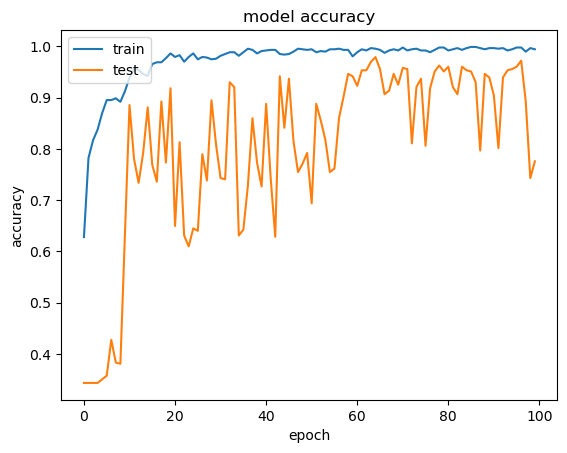

In [11]:
plt.plot(model2_history.history['accuracy'])
plt.plot(model2_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [12]:
file_path = f"./modelsave/model2.h5"
model2.save(filepath=file_path, save_format='')

In [14]:
from keras.models import load_model
model = load_model(file_path)